In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import nannernest

_RC_PARAMS = {
    "figure.figsize": (8, 4),
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 14,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.fontsize": 14,
}
for k, v in _RC_PARAMS.items():
    plt.rcParams[k] = v

In [2]:
image, banana, bread = nannernest.segmentation.run(Path("pre_sandwich.jpg"))


In [3]:
slices, banana_circle, banana_centroid, banana_skeleton = nannernest.slicing.run(
    banana.mask
)

In [4]:
slices, bread_box = nannernest.nesting.run(slices, bread)

In [5]:
from collections import namedtuple
from matplotlib import animation

In [16]:
from dataclasses import dataclass
import matplotlib as mpl
import seaborn as sns


@dataclass
class SlicePatch:
    patch: mpl.patches.Polygon
    text: mpl.text.Text
    

def plot_slices(ax, slices, fig_scaler):
    cmap = sns.color_palette("Paired")

    nested_slices = [s for s in slices if s.nested_coords is not None]
    if nested_slices:
        # Copy nested slices over and only plot these slices.
        slices = list(nested_slices)
    # else: Do nothing. We will plot all possible slices on the banana.
    bread_patches = []
    banana_patches = []
    for slice_ in slices:
        point_array = np.array(
            list(
                zip(
                    slice_.upper_right,
                    slice_.lower_right,
                    slice_.lower_left,
                    slice_.upper_left,
                )
            )
        ).T
        patch = ax.add_patch(
            mpl.patches.Polygon(
                point_array,
                closed=True,
                alpha=0.0,
                edgecolor="black",
                facecolor=cmap[slice_.index % len(cmap)],
            )
        )

        text = ax.annotate(
            f"{slice_.index}",
            slice_.centroid,
            ha="center",
            va="center",
            fontsize=12 * fig_scaler,
            alpha=0
        )
        banana_patches.append(SlicePatch(patch=patch, text=text))
        if slice_.nested_coords is not None:
            patch = ax.add_patch(
                mpl.patches.Polygon(
                    slice_.nested_coords,
                    closed=True,
                    alpha=0.0,
                    edgecolor="black",
                    facecolor=cmap[slice_.index % len(cmap)],
                    
                )
            )
            centroid = slice_.nested_coords.mean(axis=0)
            text = ax.annotate(
                f"{slice_.index}",
                centroid,
                ha="center",
                va="center",
                fontsize=12 * fig_scaler,
                alpha=0
            )
            bread_patches.append(SlicePatch(patch=patch, text=text))

    return ax, banana_patches, bread_patches


def init_fig(fig, ax, artists, fig_scaler):
    print("HERE")
    ax.axis("off")

    ax.imshow(artists["image"], aspect="equal")
    ax.set(xlim=[-0.5, width - 0.5], ylim=[-0.5, height - 0.5], aspect=1)
    ax, banana_patches, bread_patches = plot_slices(ax, slices, fig_scaler)
    artists["banana_patches"] = banana_patches
    artists["bread_patches"] = bread_patches
    print(len(artists["banana_patches"]))
    return artists


def frame_iter(artists):
    """Iterate through the days of the spectra and return
    flux and day number.
    """
    fracs = [0.5, 1.0]
    for n in range(len(artists["banana_patches"]) + 1):
        for frac in fracs:
            yield n, frac
    for n in range(len(artists["banana_patches"])-1, -1, -1):
        for frac in fracs[::-1]:
            yield n, frac
#     for n1 in range(len(artists["banana_patches"])):
#         yield n1, 0
#     for n2 in range(len(artists["bread_patches"])):
#         yield n1, n2

        
def update_artists(frame, artists, ax):
    """Update artists with data from each frame."""
    n, frac = frame
    if n > 0:
        for banana_patch, bread_patch in zip(artists["banana_patches"][:n], artists["bread_patches"][:n]):
            banana_patch.patch.set_alpha(0.5)
            banana_patch.text.set_alpha(1)

            bread_patch.patch.set_alpha(0.5)
            bread_patch.text.set_alpha(1)    
    
    if n < len(artists["banana_patches"]):
        artists["banana_patches"][n].patch.set_alpha(0.5 * frac)
        artists["banana_patches"][n].text.set_alpha(1 * frac)

    for banana_patch, bread_patch in zip(artists["banana_patches"][n:], artists["bread_patches"][n:]):
        banana_patch.patch.set_alpha(0)
        banana_patch.text.set_alpha(0)
        
        bread_patch.patch.set_alpha(0)
        bread_patch.text.set_alpha(0)
#     n1, n2 = frame
#     for patch in artists["banana_patches"][:n1]:
#         patch.patch.set_alpha(0.5)
#         patch.text.set_alpha(1)
#     for patch in artists["bread_patches"][:n2]:
#         patch.patch.set_alpha(0.5)
#         patch.text.set_alpha(1)

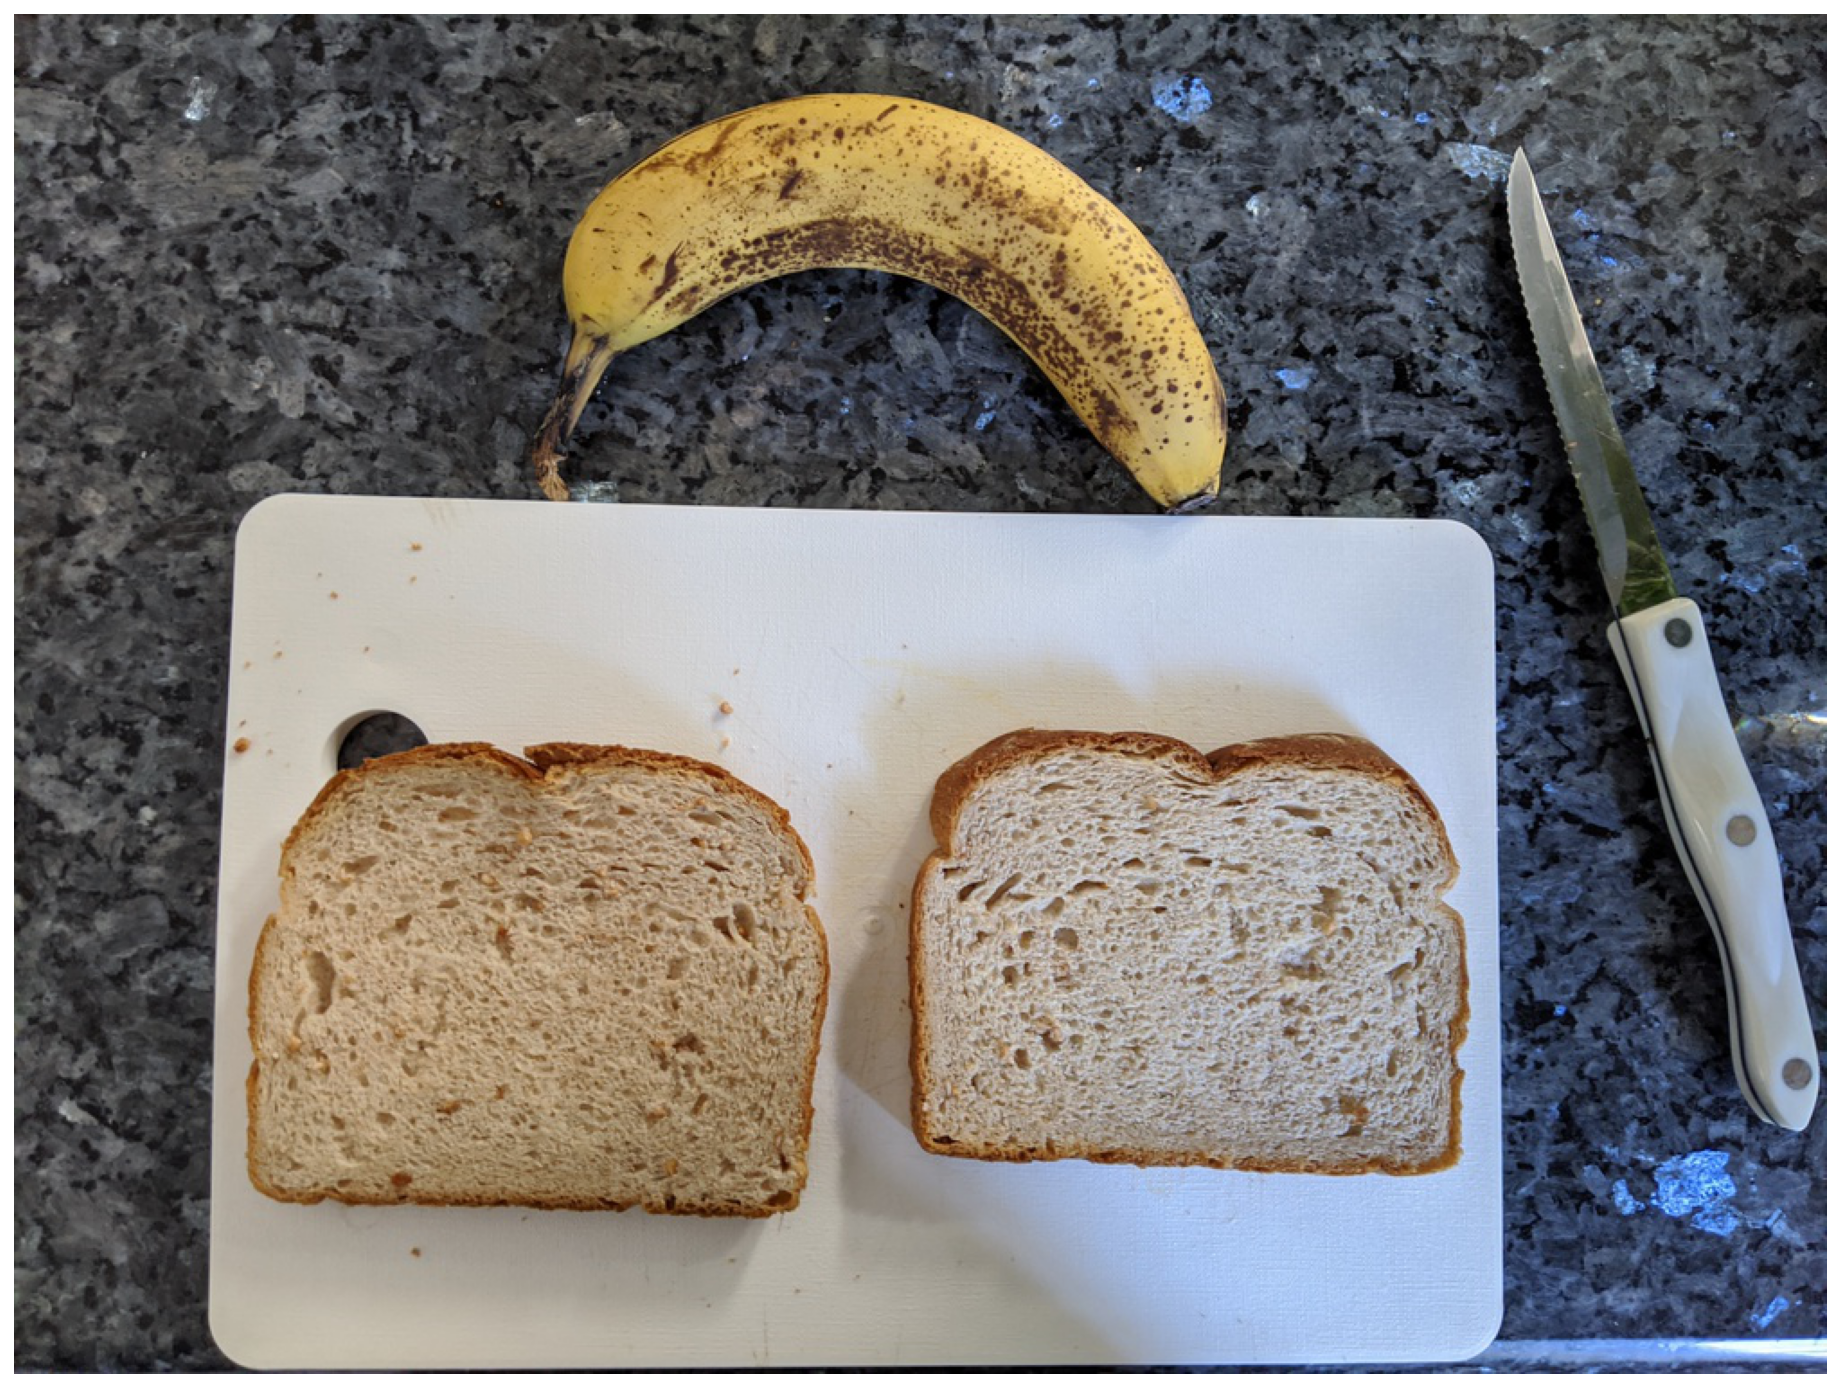

In [17]:
from functools import partial

# Default color is green   [  R,   G,   B]
mask_color = [0.0, 1.0, 0.0]

# The figure scaling stuff is from https://stackoverflow.com/a/34769840
dpi = 80
height, width, _ = np.array(image).shape

# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Use fig_scaler to scale all fonts relative to the figure size.
fig_scaler = max(figsize) / 10

# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])

Artists = namedtuple("Artists", ["image", "slices"])
artists = {"image": image, "slices": slices, "banana_patches": [], "bread_patches": []}

ax.axis("off")

ax.imshow(artists["image"], aspect="equal")
ax.set(xlim=[-0.5, width - 0.5], ylim=[-0.5, height - 0.5], aspect=1)
ax, banana_patches, bread_patches = plot_slices(ax, slices, fig_scaler)
artists["banana_patches"] = banana_patches
artists["bread_patches"] = bread_patches


# 3. Apply the three plotting functions written above
init = partial(init_fig, fig=fig, ax=ax, artists=artists, fig_scaler=fig_scaler)
step = partial(frame_iter, artists=artists)
update = partial(update_artists, artists=artists, ax=ax)

# 4. Generate the animation
anim = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=step,
#     init_func=init,
    save_count=len(list(step())),
    interval=50,
    repeat_delay=5000,
)

# 5. Save the animation
anim.save(
  filename='/tmp/banana.mp4',
  fps=24,
  extra_args=['-vcodec', 'libx264'],
  dpi=150,
)

Convert to gif
 
```commandline
ffmpeg -i banana.mp4 -vf "scale=1280:-1:lancos" -loop 0 banana.gif
```